# Lab 4: 

Lab session by:
* Daniel Hess
* Pandelis Laurens Symeonidis

Notes


lot of pairs that are not present in the training set (why hmm is bad)
we can use smoothing to fix it

lidstone smoothing?
passed to train_supervicse as estimator

HMM = nltk.HiddenMarkovModelTagger.train(train)
this already used LID (validate by comparing accuracy score)

can save the model if needed

other models we have access to in nltk:
all in tags package (they are simply taggers we can appluy thm to any sequence tagging task)
- TnT
- Perceptron

we just saw HMM in class (we will see CRF in the next sessions):
we can basically build a HMM with a CRF (CRF is more complex architectyre), has feature functions
we can change the default feature function in the CRFTagger class (for this session we DONT have to do this), the accuracy will depend on set of feature functions we are using

Exercise

download treebacnk
train 4 models for different sizes

evaluate all 24 models (test set is always senteces from 3001)
plot how accuracy changes

choose model and justify the answer
just looking at learning curves isnt enough
why? other reasons to select a model like training time. Also, inference time. Reccomendation: measure these metrics as well for all models

## Imports and setup

In [1]:
import nltk
import dill
import time
import pycrfsuite 
import pathlib

nltk.download('treebank')

train_data = nltk.corpus.treebank.tagged_sents()[:3000]
test_data = nltk.corpus.treebank.tagged_sents()[3000:]

MODELS_DIR = pathlib.Path("./lab4-models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

[nltk_data] Downloading package treebank to C:\Users\Daniel
[nltk_data]     Hess\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


## Train and save

In [2]:
def LID(fd, bins):
    """Lidstone estimator (γ=0.1)."""
    return nltk.probability.LidstoneProbDist(fd, 0.1, bins)

def train(train_data, model):

    t0 = time.perf_counter()
    
    trained_model = None
    if model == "HMM":
        trained_model = nltk.HiddenMarkovModelTagger.train(train_data, estimator=LID)

        save_path = MODELS_DIR / f"HMM-{len(train_data)}.dill"
        with open(save_path, "wb") as f:
            dill.dump(trained_model, f)

    elif model == "TnT":
        TnT = nltk.tag.tnt.TnT()
        TnT.train(train_data)
        trained_model = TnT

        save_path = MODELS_DIR / f"TnT-{len(train_data)}.dill"
        with open(save_path, "wb") as f:
            dill.dump(trained_model, f)

    elif model == "Perceptron":
        PER = nltk.tag.perceptron.PerceptronTagger(load=False)
        PER.train(train_data)
        trained_model = PER

        save_path = MODELS_DIR / f"Perceptron-{len(train_data)}.dill"
        with open(save_path, "wb") as f:
            dill.dump(trained_model, f)

    elif model == "CRF":
        CRF = nltk.tag.CRFTagger()
        save_path = MODELS_DIR / f"CRF-{len(train_data)}.crfsuite"
        CRF.train(train_data, str(save_path))

    else:
        raise Exception("Not valid model")

    train_seconds = time.perf_counter() - t0
    
    print(f"[✓] Trained {model} on {len(train_data)} sents in {train_seconds:.2f}s → {save_path}")
    
    return train_seconds
    




## Execution

### Training models

In [3]:
models = ["HMM", "TnT", "Perceptron", "CRF"] 
sizes = [500, 1000, 1500, 2000, 2500, 3000]

training_times = {model: [] for model in models}

for model in models:
    for size in sizes:
        t = train(train_data[:size], model)
        training_times[model].append(t)


[✓] Trained HMM on 500 sents in 0.17s → lab4-models\HMM-500.dill
[✓] Trained HMM on 1000 sents in 0.33s → lab4-models\HMM-1000.dill
[✓] Trained HMM on 1500 sents in 0.50s → lab4-models\HMM-1500.dill
[✓] Trained HMM on 2000 sents in 0.67s → lab4-models\HMM-2000.dill
[✓] Trained HMM on 2500 sents in 0.83s → lab4-models\HMM-2500.dill
[✓] Trained HMM on 3000 sents in 0.98s → lab4-models\HMM-3000.dill
[✓] Trained TnT on 500 sents in 0.13s → lab4-models\TnT-500.dill
[✓] Trained TnT on 1000 sents in 0.25s → lab4-models\TnT-1000.dill
[✓] Trained TnT on 1500 sents in 0.35s → lab4-models\TnT-1500.dill
[✓] Trained TnT on 2000 sents in 0.45s → lab4-models\TnT-2000.dill
[✓] Trained TnT on 2500 sents in 0.57s → lab4-models\TnT-2500.dill
[✓] Trained TnT on 3000 sents in 0.62s → lab4-models\TnT-3000.dill
[✓] Trained Perceptron on 500 sents in 1.21s → lab4-models\Perceptron-500.dill
[✓] Trained Perceptron on 1000 sents in 2.36s → lab4-models\Perceptron-1000.dill
[✓] Trained Perceptron on 1500 sents in 

### Test models

In [4]:
import matplotlib.pyplot as plt

models = ["HMM", "TnT", "Perceptron", "CRF"] 
sizes = [500, 1000, 1500, 2000, 2500, 3000]
results = {model: [] for model in models}

for model in models:
    for size in sizes:
        
        if model == "CRF":
            save_path = MODELS_DIR / f"{model}-{size}.crfsuite"
            trained_model = nltk.tag.CRFTagger()
            trained_model.set_model_file(str(save_path))
        else:
            filename = MODELS_DIR / f"{model}-{size}.dill"
            with open(filename, 'rb') as f:
                trained_model = dill.load(f)

        if (trained_model is None):
            print(filename)

        accuracy = trained_model.accuracy(test_data)
        print(f"model = {model} | size = {size} | accuracy = {accuracy}")
        results[model].append(accuracy)

model = HMM | size = 500 | accuracy = 0.793654219728038
model = HMM | size = 1000 | accuracy = 0.8347938700625944
model = HMM | size = 1500 | accuracy = 0.8594431254047054
model = HMM | size = 2000 | accuracy = 0.8762357004101015
model = HMM | size = 2500 | accuracy = 0.8864666522771423
model = HMM | size = 3000 | accuracy = 0.8984243470753291
model = TnT | size = 500 | accuracy = 0.7472911720267645
model = TnT | size = 1000 | accuracy = 0.7962875026980358
model = TnT | size = 1500 | accuracy = 0.827498381178502
model = TnT | size = 2000 | accuracy = 0.8484783077919275
model = TnT | size = 2500 | accuracy = 0.8622922512410964
model = TnT | size = 3000 | accuracy = 0.875545003237643
model = Perceptron | size = 500 | accuracy = 0.9144398877617095
model = Perceptron | size = 1000 | accuracy = 0.9324843513921864
model = Perceptron | size = 1500 | accuracy = 0.9422404489531621
model = Perceptron | size = 2000 | accuracy = 0.9477660263328297
model = Perceptron | size = 2500 | accuracy = 0.95

## Analysis

The learning curves show steady gains in accuracy for all models as we increase training data from 500 to 3,000 sentences, with diminishing returns after around 2000-2500. The perceptron is the highest performing model (≈95–96% at 3k), CRF is very close behind (≈95%), while HMM and TnT lag (≈90% and ≈88%). These results clearly show the differences in each models complexity. HMM and TnT are simpler, probability/count-based taggers and struggle more with rare or unseen words while perceptrons and CRF look at the surrounding words (context) and can learn better patterns from that information. 

While improoving accuracy, more complex models tend to have more complex training, which can be seen when evaluating and comparing each of the models training time. HMM and TnT are extremely fast and scale almost linearly (about ~1 second at 3k in our runs). The Perceptron takes a few seconds and grows steadily. CRF is the slowest by a large margin (≈14 seconds at 3k). In summary higher accuracy generally comes with longer training.

Putting both plots together, the most practical choice would be using perceptron as it gives the best accuracy while still training faster than it's competitor CRF. 

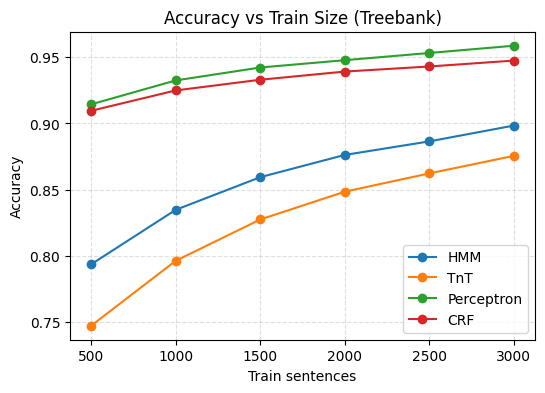

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
for m in models:  # ["HMM","TnT","Perceptron","CRF"]
    plt.plot(sizes, results[m], marker="o", label=m)
plt.xlabel("Train sentences")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Train Size (Treebank)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()

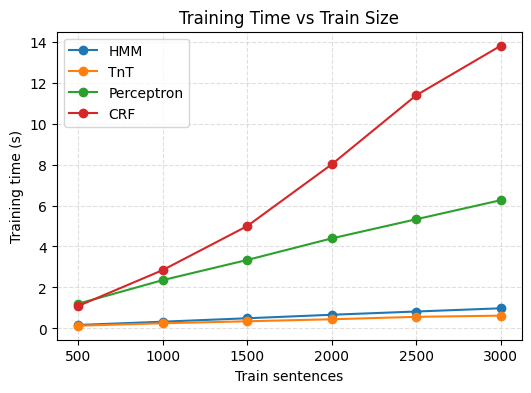

In [6]:
plt.figure(figsize=(6,4))
for m in models:
    plt.plot(sizes, training_times[m], marker="o", label=m)
plt.xlabel("Train sentences")
plt.ylabel("Training time (s)")
plt.title("Training Time vs Train Size")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()